## Keep Up Data Science Interview Challenge

For this exercise, you will analyze a dataset from Amazon. The data format and a
sample entry are shown on the next page. 

A. (Suggested duration: 90 mins)
With the given data for 548552 products, perform exploratory analysis and make
suggestions for further analysis on the following aspects.  

## 1. Trustworthiness of ratings
Ratings are susceptible to manipulation, bias etc. What can you say (quantitatively
speaking) about the ratings in this dataset?  

In [16]:
import pandas as pd
import datetime
import seaborn as sns
%matplotlib inline

We will begin by reading in the data and parsing it:

In [4]:
# Read the data, I've never used gzip but it is quite neat!
import gzip
with gzip.open('amazon-meta.txt.gz', 'rt') as f:
    file_data = f.read()
f.close()

In [5]:
# Parse and group the data by  product
product_group = []
add = []

for string in file_data.split('\n')[3:]:
    if string != '':
        add.append(string)
    else:
        product_group.append(add)
        add = []

In [8]:
# Extract rating info from each product group into a dataframe
ttl_ratings = {}

for i in product_group:
    ident, total, downloaded, avg_rating = '', '', '', ''
    for j in i:
        if j.startswith('Id:'):
            ident = j.split()[-1]
        elif j.startswith('  reviews:'):
            total = j.split()[2]
            dl = j.split()[4]
            avg_rate = j.split()[7]
        elif j.startswith('  discontinued product'):
            skip = True
    if skip == False:
        ttl_ratings[ident] = [total, dl, avg_rate]
    else:
        skip = False

#building the ratings data frame
df_ratings = pd.DataFrame.from_dict(ttl_ratings)
df_ratings = df_ratings.T.reset_index(drop=False)
df_ratings.columns = ['id', 'total', 'downloaded', 'avg_rating']
df_ratings = df_ratings.iloc[1:]
df_ratings['id']  = df_ratings['id'].astype(int)
df_ratings['total']  = df_ratings['total'].astype(int)
df_ratings['downloaded']  = df_ratings['downloaded'].astype(int)
df_ratings['avg_rating']  = df_ratings['avg_rating'].astype(float)
df_ratings = df_ratings.sort_values('id')
df_ratings.head()

,id,total,downloaded,avg_rating
1,1,2,2,5.0
109902,2,12,12,4.5
219674,3,1,1,5.0
329477,4,1,1,4.0
439371,5,0,0,0.0


We now have a dataframe of rating information. Let's explore it:

In [9]:
# Are there products with more ratings than downloads?
df_ratings[df_ratings['total'] > df_ratings['downloaded']].head()

,id,total,downloaded,avg_rating
102215,193,261,260,3.0
292161,366,10,5,4.5
295451,369,416,5,5.0
297637,371,416,415,5.0
300934,374,7,5,3.5


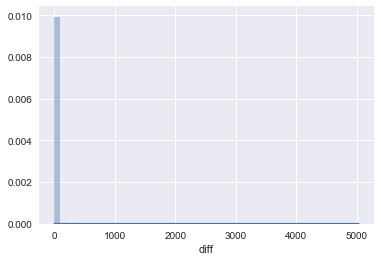

In [19]:
# let's look closer at the difference between ratings and downloads
df_ratings['diff'] = df_ratings['total'] - df_ratings['downloaded']
df_ratings = df_ratings.sort_values('diff', ascending=False)
sns.distplot(df_ratings['diff'])

Some products have a rather unusual amount of ratings compared to the number of product downloads, which could signify ratings manipulation.

## 2. Category bloat
Consider the product group named 'Books'. Each product in this group is associated with
categories. Naturally, with categorization, there are tradeoffs between how broad or
specific the categories must be.  
  
For this dataset, quantify the following:  
a. Is there redundancy in the categorization? How can it be identified/removed?  
b. Is it possible to reduce the number of categories drastically (say to 10% of existing categories) by sacrificing relatively few category entries (say close to 10%)?

In [24]:
product_group[0:3]

[['Id:   0', 'ASIN: 0771044445', '  discontinued product'],
 ['Id:   1',
  'ASIN: 0827229534',
  '  title: Patterns of Preaching: A Sermon Sampler',
  '  group: Book',
  '  salesrank: 396585',
  '  similar: 5  0804215715  156101074X  0687023955  0687074231  082721619X',
  '  categories: 2',
  '   |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368]',
  '   |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Sermons[12370]',
  '  reviews: total: 2  downloaded: 2  avg rating: 5',
  '    2000-7-28  cutomer: A2JW67OY8U6HHK  rating: 5  votes:  10  helpful:   9',
  '    2003-12-14  cutomer: A2VE83MZF98ITY  rating: 5  votes:   6  helpful:   5'],
 ['Id:   2',
  'ASIN: 0738700797',
  '  title: Candlemas: Feast of Flames',
  '  group: Book',
  '  salesrank: 168596',
  '  similar: 5  0738700827  1567184960  1567182836  0738700525  0738700940',
  '  categories: 2',
  '   |Books[283155]|Subjects[1000]|Re

It is clear that books with more than one category show serious amounts of redundancy in the first few layers of categorizations. Let's dig deeper:

In [26]:
# Extract category info from each book into a list
categories = []
count_of_books = 0

for i in product_group:
    prod_type = ''
    for j in i:
        if j.startswith('  group:'):
            prod_type = j.split()[-1]
        if prod_type == 'Book':
            if j.startswith('   |'):
                categories.append(j.strip())
    if prod_type == 'Book':
        count_of_books += 1
            
print('There are {} total books.'.format(count_of_books))
print('There are {} total category branches across all books.'.format(len(categories)))
print('There are {} unique category branches across all books.'.format(len(set(categories))))

There are 393561 total books.
There are 1440329 total category branches across all books.
There are 12853 unique category branches across all books.


In [29]:
# How many sub-categories are there?
sub_categories = []
for i in categories:
    for j in i.split('|')[1:]:
        sub_categories.append(j)
        
print('There are {} total sub-categories across all books.'.format(len(sub_categories)))
print('There are {} unique sub-categories across all books.'.format(len(set(sub_categories))))

There are 7891047 total sub-categories across all books.
There are 14923 unique sub-categories across all books.


In [32]:
# Create a dataframe to show sub-category counts
# I asked other students for help on this question
from collections import Counter

count_of_categories = pd.DataFrame.from_dict(Counter(sub_categories), orient='index').reset_index()
count_of_categories = count_of_categories.sort_values(0, ascending=False)
count_of_categories.head()

,index,0
0,Books[283155],1286848
1,Subjects[1000],1222638
130,Children's Books[4],134263
125,Amazon.com Stores[285080],123925
124,[265523],123925


If we target the most common sub-categories across all books (and assume that this does not harm the searching structure too much) and aim to drop them in favor of the more specific sub-categories, perhaps we can reduce the number of unique sub-categories.

In [34]:
# Determine what percent of category appearances is the top 10% of sub-category titles
# I asked other students for help on this question

print('The first {:.2f}% of largest sub-category titles makes up {:.2f}% of the sub-category volume.'\
          .format((len(count_of_categories.iloc[0:1400])/len(count_of_categories))*100, 
                  count_of_categories.iloc[0:1400][0].sum()/count_of_categories[0].sum()*100))

The first 9.38% of largest sub-category titles makes up 90.04% of the sub-category volume.


According to our analysis, we can reduce the number of sub-category titles by 90% by removing the top 10% of most occuring sub-category titles.

<b>B. (Suggested duration: 30 mins)</b>  
Give the number crunching a rest! Just think about these problems.  
  
<b>1. Algorithm thinking</b>  
How would you build the product categorization from scratch, using similar/co-purchased
information?  
  
<b>2. Product thinking</b>  
Now, put on your 'product thinking' hat:  
a. Is it a good idea to show users the categorization hierarchy for items?  
b. Is it a good idea to show users similar/co-purchased items?  
c. Is it a good idea to show users reviews and ratings for items?  
d. For each of the above, why? How will you establish the same?  

#1. Creating product categorization would be very similar to my Capstone Project # 2 where I would look at clustering based on vectors and tf-idf matrices. I would then tune parameters to understnad the primary categories.

#2a. It is a good idea to show users the categories for ease of use, however it does introduce bias when it comes to products that are displayed and offered.

#2b. It is a good idea to show users similar items for purchase. Recommendation systems either item or user based can be of value in these scenarios. 

#2c. it is a good idea to show users reviews and ratings as it builds trust in the product.